In [1]:
try:
    import pandas as pd
    import psutil
except ImportError:
    %pip install -qU pandas psutil
    import pandas as pd
    import psutil

import os, time, gc, statistics

DATASET_PATH = "C:/Users/Subhobroto Sasmal/Downloads/diabetes.csv"
TMP_WRITE    = "./pandas_tmp.csv"
REPS         = 5
MB           = 1_048_576
OPS          = ["read", "write", "group", "sort", "to_np"]
NROWS        = 30_300_000   # read only the first 30,300,000 rows

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at: {DATASET_PATH}")

def mem_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def median(seq):
    return statistics.median(seq)

def show(result_dict, lib_name):
    print(f"\n📊 {lib_name.upper()} median results ({REPS} runs)")
    print("{:<10} {:>10} {:>10}".format("Stage", "Time (s)", "Memory (MB)"))
    for stage, (sec, mb) in result_dict.items():
        print(f"{stage:<10} {sec:>10.3f} {mb:>10.1f}")

times = {op: [] for op in OPS}
mems  = {op: [] for op in OPS}

for run in range(1, REPS + 1):
    print(f"▶️  Run {run}/{REPS}", end="\r")

    t0 = time.perf_counter()
    df = pd.read_csv(DATASET_PATH, nrows=NROWS)
    dt = time.perf_counter() - t0
    times["read"].append(dt)
    mems["read"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    df.to_csv(TMP_WRITE, index=False)
    dt = time.perf_counter() - t0
    times["write"].append(dt)
    mems["write"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.groupby(df.columns[0]).first()
    dt = time.perf_counter() - t0
    times["group"].append(dt)
    mems["group"].append(mem_bytes() / MB)

    num_col = df.select_dtypes(include="number").columns[0]
    t0 = time.perf_counter()
    _ = df.sort_values(num_col)
    dt = time.perf_counter() - t0
    times["sort"].append(dt)
    mems["sort"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.to_numpy()
    dt = time.perf_counter() - t0
    times["to_np"].append(dt)
    mems["to_np"].append(mem_bytes() / MB)

    del df
    gc.collect()

summary = {k: (median(times[k]), median(mems[k])) for k in OPS}
show(summary, "pandas")

try:
    os.remove(TMP_WRITE)
except FileNotFoundError:
    pass


▶️  Run 5/5
📊 PANDAS median results (5 runs)
Stage        Time (s) Memory (MB)
read           18.116     4262.7
write         116.008     4258.1
group           1.568     2185.5
sort            2.768     4497.2
to_np           1.093     4266.0


In [2]:
try:
    import polars as pl
    import psutil
except ImportError:
    %pip install -qU polars psutil
    import polars as pl
    import psutil

import os, time, gc, statistics

DATASET_PATH = "C:/Users/Subhobroto Sasmal/Downloads/diabetes.csv"
TMP_WRITE    = "./polars_tmp.csv"
REPS         = 5
MB           = 1_048_576
NROWS        = 30_300_000
OPS          = ["read", "write", "group", "sort", "to_np"]

if not os.path.isfile(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at: {DATASET_PATH}")

def mem_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def median(seq):
    return statistics.median(seq)

def show(result_dict, lib_name="polars"):
    print(f"\n📊 {lib_name.upper()} median results ({REPS} runs)")
    print("{:<10} {:>10} {:>10}".format("Stage", "Time (s)", "Memory (MB)"))
    for stage, (sec, mb) in result_dict.items():
        print(f"{stage:<10} {sec:>10.3f} {mb:>10.1f}")

NUMERIC_DTYPES = {
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64
}

times = {op: [] for op in OPS}
mems  = {op: [] for op in OPS}

for run in range(1, REPS + 1):
    print(f"▶️  Run {run}/{REPS}", end="\r")

    t0 = time.perf_counter()
    df = pl.read_csv(DATASET_PATH, n_rows=NROWS)
    dt = time.perf_counter() - t0
    times["read"].append(dt)
    mems["read"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    df.write_csv(TMP_WRITE)
    dt = time.perf_counter() - t0
    times["write"].append(dt)
    mems["write"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.group_by(df.columns[0]).first()
    dt = time.perf_counter() - t0
    times["group"].append(dt)
    mems["group"].append(mem_bytes() / MB)

    num_col = next(col for col, dtp in zip(df.columns, df.dtypes) if dtp in NUMERIC_DTYPES)
    t0 = time.perf_counter()
    _ = df.sort(num_col)
    dt = time.perf_counter() - t0
    times["sort"].append(dt)
    mems["sort"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.to_numpy()
    dt = time.perf_counter() - t0
    times["to_np"].append(dt)
    mems["to_np"].append(mem_bytes() / MB)

    del df
    gc.collect()

print("✅  All runs finished.")

summary = {k: (median(times[k]), median(mems[k])) for k in OPS}
show(summary, "polars")

try:
    os.remove(TMP_WRITE)
except FileNotFoundError:
    pass


✅  All runs finished.

📊 POLARS median results (5 runs)
Stage        Time (s) Memory (MB)
read            4.034    10497.6
write           5.574     8653.4
group           0.348     8705.9
sort            2.004    10470.1
to_np           1.366     9948.7


In [3]:
try:
    import datatable as dt
    import psutil
except ImportError:
    %pip install -qU datatable psutil
    import datatable as dt
    import psutil

import os, time, gc, statistics

DATASET_PATH = "C:/Users/Subhobroto Sasmal/Downloads/diabetes.csv"
TMP_WRITE    = "./dt_tmp.csv"
REPS         = 5
MB           = 1_048_576
NROWS        = 30_300_000
OPS          = ["read", "write", "group", "sort", "to_np"]

if not os.path.isfile(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset not found at: {DATASET_PATH}")

def mem_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def median(seq):
    return statistics.median(seq)

def show(result_dict, lib_name="datatable"):
    print(f"\n📊 {lib_name.upper()} median results ({REPS} runs)")
    print("{:<10} {:>10} {:>10}".format("Stage", "Time (s)", "Memory (MB)"))
    for stage, (sec, mb) in result_dict.items():
        print(f"{stage:<10} {sec:>10.3f} {mb:>10.1f}")

NUMERIC_DTYPES = {dt.Type.int32, dt.Type.int64, dt.Type.float32, dt.Type.float64}

times = {op: [] for op in OPS}
mems  = {op: [] for op in OPS}

for run in range(1, REPS + 1):
    print(f"▶️  Run {run}/{REPS}", end="\r")

    t0 = time.perf_counter()
    df = dt.fread(DATASET_PATH)[:NROWS, :]
    dt_read = time.perf_counter() - t0
    times["read"].append(dt_read)
    mems["read"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    df.to_csv(TMP_WRITE)
    dt_write = time.perf_counter() - t0
    times["write"].append(dt_write)
    mems["write"].append(mem_bytes() / MB)

    key = df.names[0]
    t0 = time.perf_counter()
    _ = df[:, dt.first(dt.f[:]), dt.by(key)]
    dt_group = time.perf_counter() - t0
    times["group"].append(dt_group)
    mems["group"].append(mem_bytes() / MB)

    num_col = next(name for name, typ in zip(df.names, df.types) if typ in NUMERIC_DTYPES)
    t0 = time.perf_counter()
    _ = df.sort(num_col)
    dt_sort = time.perf_counter() - t0
    times["sort"].append(dt_sort)
    mems["sort"].append(mem_bytes() / MB)

    t0 = time.perf_counter()
    _ = df.to_numpy()
    dt_np = time.perf_counter() - t0
    times["to_np"].append(dt_np)
    mems["to_np"].append(mem_bytes() / MB)

    del df
    gc.collect()

print("✅  All runs finished.")

summary = {k: (median(times[k]), median(mems[k])) for k in OPS}
show(summary, "datatable")

try:
    os.remove(TMP_WRITE)
except FileNotFoundError:
    pass


✅  All runs finished.

📊 DATATABLE median results (5 runs)
Stage        Time (s) Memory (MB)
read            2.898     8753.0
write          82.809     5836.6
group           0.703     2585.3
sort            0.307     2585.3
to_np           1.092     4550.3


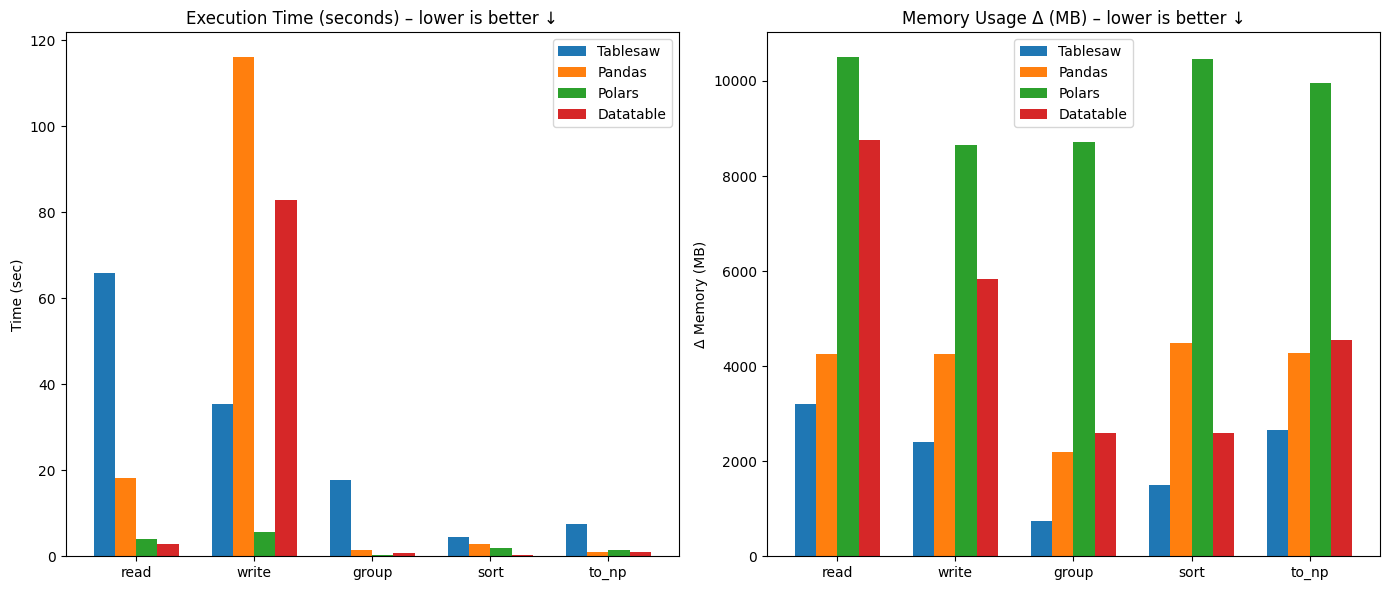

In [4]:
import matplotlib.pyplot as plt
import numpy as np

stages = ["read", "write", "group", "sort", "to_np"]

tablesaw_time = np.array([65.911, 35.350, 17.722, 4.419, 7.568])
pandas_time   = np.array([18.116, 116.008, 1.568, 2.768, 1.093])
polars_time   = np.array([4.034, 5.574, 0.348, 2.004, 1.366])
datatable_time= np.array([2.898, 82.809, 0.703, 0.307, 1.092])

tablesaw_mem  = np.array([3202.0, 2398.0, 733.0, 1500.0, 2667.0])
pandas_mem    = np.array([4262.7, 4258.1, 2185.5, 4497.2, 4266.0])
polars_mem    = np.array([10497.6, 8653.4, 8705.9, 10470.1, 9948.7])
datatable_mem = np.array([8753.0, 5836.6, 2585.3, 2585.3, 4550.3])

x = np.arange(len(stages))
w = 0.18

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(x - 1.5*w, tablesaw_time, width=w, label="Tablesaw")
ax[0].bar(x - 0.5*w, pandas_time,   width=w, label="Pandas")
ax[0].bar(x + 0.5*w, polars_time,   width=w, label="Polars")
ax[0].bar(x + 1.5*w, datatable_time,width=w, label="Datatable")
ax[0].set_xticks(x)
ax[0].set_xticklabels(stages)
ax[0].set_ylabel("Time (sec)")
ax[0].set_title("Execution Time (seconds) – lower is better ↓")
ax[0].legend()

ax[1].bar(x - 1.5*w, tablesaw_mem,  width=w, label="Tablesaw")
ax[1].bar(x - 0.5*w, pandas_mem,    width=w, label="Pandas")
ax[1].bar(x + 0.5*w, polars_mem,    width=w, label="Polars")
ax[1].bar(x + 1.5*w, datatable_mem, width=w, label="Datatable")
ax[1].set_xticks(x)
ax[1].set_xticklabels(stages)
ax[1].set_ylabel("Δ Memory (MB)")
ax[1].set_title("Memory Usage Δ (MB) – lower is better ↓")
ax[1].legend()

plt.tight_layout()
plt.show()
